<a href="https://colab.research.google.com/github/davidsohutskay/nerveWoundPython/blob/main/nerveWoundSolverDiffraxNumPyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an ODE solver for a stroke wound healing using Diffrax and Numpyro

Includes:

*   Cells:
*   Cytokines:
*   Matrix:

In [ ]:
!pip install diffrax
!pip install pyvista
!pip install numpyro
!pip install -U jax jaxlib

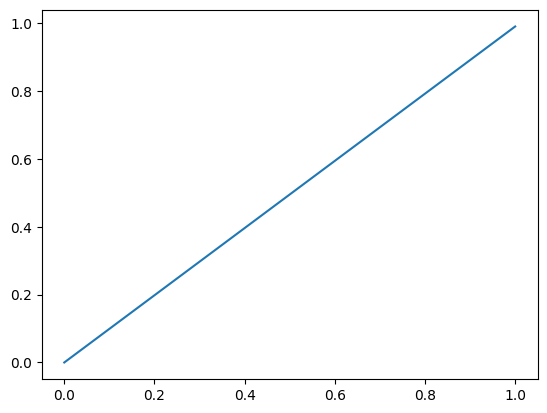

In [ ]:
x = np.linspace(0,1,100)

y = 1/(1+x)

#plt.plot(x,y)

NGF = 0.01

dNGF = (x/(1 + NGF))

plt.plot(x,dNGF)


ODE Solver and Least Squares Fit

For comparison, much simpler to calculate but does not give uncertainty

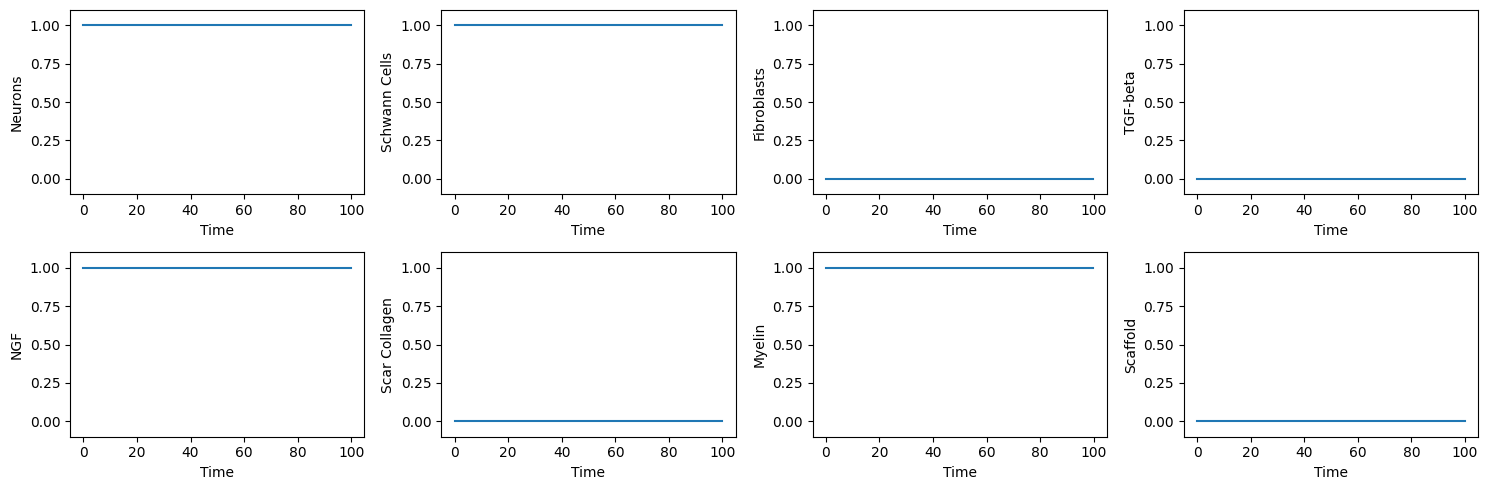

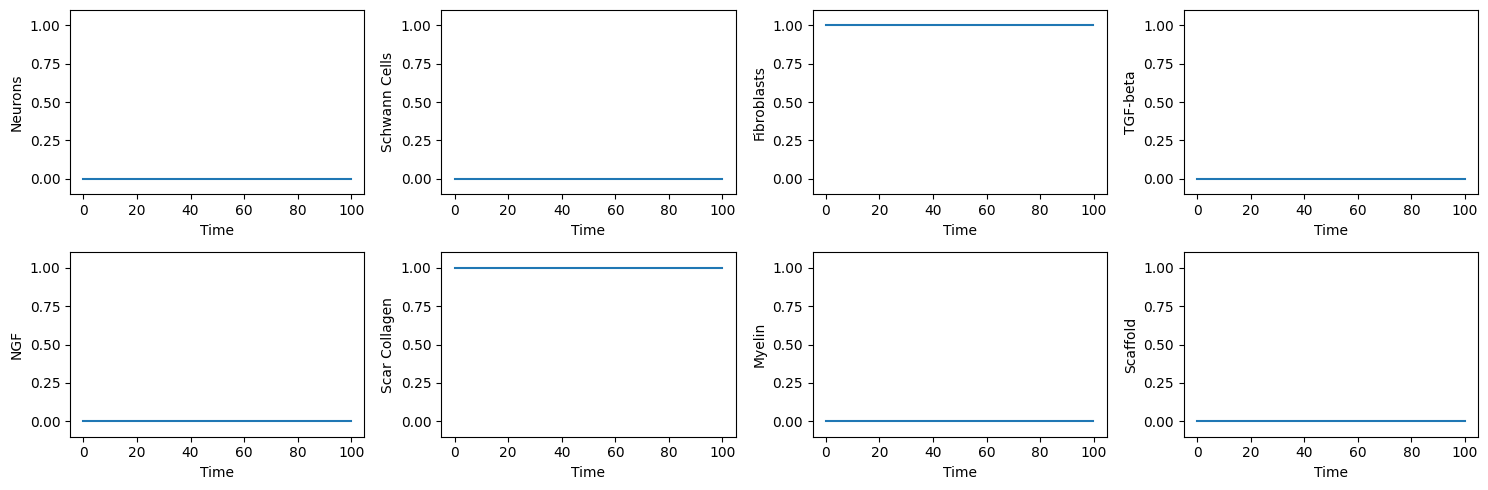

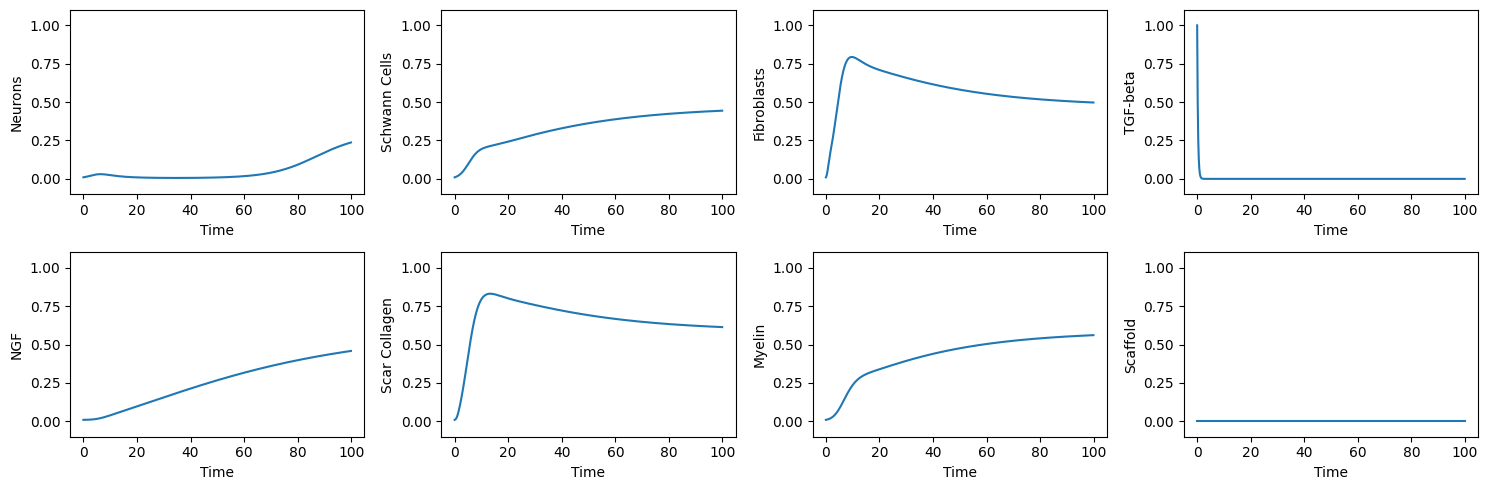

In [ ]:
import os
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import pandas as pd
from scipy.optimize import least_squares

########################################
# DEFINE PARAMETERS
########################################

## Training grid
XMIN, XMAX = -1.0, 1.0
YMIN, YMAX = -1.0, 1.0
TMIN, TMAX = 0.0, 1.0
RMIN, RMAX = 0.15, 0.25
x_length = 50 # Remember we are mapping -X to X to -1 to 1
y_length = 50
x_center_scaled = (XMIN + XMAX)/2
y_center_scaled = (YMIN + YMAX)/2
rho_phys = 1000
rho_wound = 0
c_phys = 0
c_wound = 1e-4
stress_phys = 1
rho_scaled = 1
rho_phys_scaled = 1
S_phys_scaled = 1
c_scaled = 1
phif_scaled = 1
t_phys = 336

# Mechanics
#kv = 0.76; # volumetric penalty for incompressibility
k0 = 0.0511/stress_phys; # 0.0511; neo hookean for skin, used previously, in MPa
kf = 0.015/stress_phys; # stiffness of collagen in MPa, from previous paper
k2 = 0.048; # nonlinear exponential coefficient, non-dimensional
t_rho = 0.005/stress_phys; # 0.0045/rho_phys force of fibroblasts in MPa, this is per cell. so, in an average sense this is the production by the natural density See Koppenol
t_rho_c = t_rho*10; # 0.045/rho_phys force of myofibroblasts enhanced by chemical, I'm assuming normalized chemical, otherwise I'd have to add a normalizing constant
K_t = 0.3; # Saturation of mechanical force by collagen
K_t_c = 1/10.; # saturation of chemical on force. this can be calculated from steady state
vartheta_e = 2.; # physiological state of area stretch
gamma_theta = 5.; # sensitivity of heaviside function

# Transport
# rho F
D_rho_rho = 0.0833*t_phys/(x_length*x_length); # 0.0833 diffusion of cells in [mm^2/hour], not normalized
D_rho_c = (-1.66e-12*10/c_wound)*t_phys/(x_length*x_length); # diffusion of chemotactic gradient, an order of magnitude greater than random walk [mm^2/hour], not normalized
D_c_c = 0.01208*t_phys/(x_length*x_length); # 0.15 diffusion of chemical TGF, not normalized. Updated from Murphy
p_rho = 0.034/2*t_phys; # in 1/hour production of fibroblasts naturally, proliferation rate, not normalized, based on data of doubling rate from commercial use
p_rho_c = p_rho/2; # production enhanced by the chem, if the chemical is normalized, then suggest two fold,
p_rho_theta = p_rho/2; # enhanced production by theta
K_rho_c = 1/10.; # saturation of cell proliferation by chemical, this one is definitely not crucial, just has to be small enough <cmax
K_rho_rho = 10000/rho_phys # saturation of cell by cell, from steady state
d_rho = p_rho*(1-1/K_rho_rho) # percent of cells die per day, 10% in the original, now much less, determined to keep cells in dermis constant

# rho N
p_N = 0.034/2*t_phys; # in 1/hour production of fibroblasts naturally, proliferation rate, not normalized, based on data of doubling rate from commercial use
p_N_c = p_N/10; # production enhanced by the chem, if the chemical is normalized, then suggest two fold,
K_N_c = 1/1.; # saturation of cell proliferation by chemical, this one is definitely not crucial, just has to be small enough <cmax
K_N_N = 10000/rho_phys # saturation of cell by cell, from steady state
d_N = (p_N + (p_N_c/(K_N_c+1)))*(1-1/K_N_N) # percent of cells die per day, 10% in the original, now much less, determined to keep cells in dermis constant
#d_N = (p_N)*(1-1/K_N_N) # percent of cells die per day, 10% in the original, now much less, determined to keep cells in dermis constant

# rho SC
p_S = 0.034/2*t_phys; # in 1/hour production of fibroblasts naturally, proliferation rate, not normalized, based on data of doubling rate from commercial use
K_S_S = 10000/rho_phys # saturation of cell by cell, from steady state
d_S = p_S*(1-1/K_S_S) # percent of cells die per day, 10% in the original, now much less, determined to keep cells in dermis constant

# c TGF
p_c_rho = 90e-16*t_phys/c_wound/c_wound; # 90.0e-16/rho_phys production of c by cells in g/cells/h
p_c_thetaE = 300e-16*t_phys/c_wound/c_wound; # 300.0e-16/rho_phys coupling of elastic and chemical, three fold
K_c_c = 1./c_wound; # saturation of chem by chem, from steady state
d_c = 0.01*t_phys; # 0.01 decay of chemical in 1/hours

# c NGF
p_NGF_S = 0.034
K_NGF_NGF = 1; # saturation of chem by chem, from steady state
#d_NGF = 0.01*t_phys; # 0.01 decay of chemical in 1/hours
d_NGF = p_NGF_S*(1/(K_NGF_NGF + 1))

# Local solver parameters
# phi F
p_phi = 0.002*t_phys; # production by fibroblasts, natural rate in percent/hour, 5% per day
p_phi_c = p_phi; # production up-regulation, weighted by C and rho
p_phi_theta = p_phi; # mechanosensing upregulation. no need to normalize by Hmax since Hmax = 1
K_phi_c = 0.0001/c_wound; # saturation of C effect on deposition.
d_phi = 0.000970*t_phys; # rate of degradation, in the order of the wound process, 100 percent in one year for wound, means 0.000116 effective per hour means degradation = 0.002 - 0.000116
d_phi_rho_c = 0.5*d_phi; #0.000194; // degradation coupled to chemical and cell density to maintain phi equilibrium
K_phi_rho = p_phi/d_phi - 1; # saturation of collagen fraction itself, from steady state

# phi M

# phi S

tau_omega = 10./(K_phi_rho+1); # time constant for angular reorientation, think 100 percent in one year
tau_kappa = 1./(K_phi_rho+1); # time constant, on the order of a year
gamma_kappa = 5.; # exponent of the principal stretch ratio
tau_lamdaP_a = 1.0/(K_phi_rho+1); # 1.0 time constant for direction a, on the order of a year
tau_lamdaP_s = 1.0/(K_phi_rho+1); # 1.0 time constant for direction s, on the order of a year
tau_lamdaP_n = 1.0/(K_phi_rho+1); # 1.0 time constant for direction s, on the order of a year

########################################
# ODE MODEL
########################################

# Define ODE system
def dxdt(t, y, args):
    # Nerve, Schwann, FB, TGF, NGF, Fibrous Scar, Myelin, Scaffold
    N, S, rho, TGF, NGF, phif, phim, phis = y

    # Import parameters
    #k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = args

    # He = coupling(u,)
    He = 0

    # Cells/cytokine
    kk = 10
    dNdt = (kk/(kk+phif))*(p_N + p_N_c*NGF/(K_N_c + NGF))*(1 - N/K_N_N)*N - d_N*N
    dSdt = (kk/(kk+phif))*(p_S)*(1 - S/K_S_S)*S - d_S*S
    drhodt = (kk/(kk+phim))*(p_rho + p_rho_c*TGF/(K_rho_c + TGF))*(1 - rho/K_rho_rho)*rho - d_rho*rho
    # dSdt = (p_rho + p_rho_c*NGF/(K_rho_c + NGF))*(1 - S/K_rho_rho)*S - p_rho*(1 - (1-rho)/K_rho_rho)*S
    # drhodt = (p_rho + p_rho_c*TGF/(K_rho_c + TGF))*(1 - rho/K_rho_rho)*rho - p_rho*(1 - (1-S)/K_rho_rho)*rho
    dTGFdt = p_c_rho*(rho/(K_c_c + TGF)) - d_c*TGF
    dNGFdt = p_NGF_S*(S/(K_NGF_NGF + NGF)) - d_NGF*NGF

    # ODEs
    dphifdt = (p_phi + p_phi_c*TGF/(K_phi_c + TGF))*(rho/(K_phi_rho + phif)) - (d_phi + d_phi_rho_c*rho*TGF)*phif
    dphimdt = (p_phi)*(S/(K_phi_rho + phim)) - (d_phi)*phim #  + p_phi_c*NGF/(K_phi_c + NGF)
    dphisdt = - (d_phi + d_phi_rho_c*rho*TGF)*phis

    return jnp.stack([dNdt, dSdt, drhodt, dTGFdt, dNGFdt, dphifdt, dphimdt, dphisdt])

terms = ODETerm(dxdt)

########################################
# INITIALIZE SOLVER
########################################

# Set the initial conditions and time points
# Neuron, Schwann, Fibroblast, TGF, NGF, ECM, Myelin, Scaffold
y0_nerve = jnp.array([1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]) # Nerve
y0_tissue = jnp.array([0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]) # Tissue
y0_wound = jnp.array([0.01, 0.01, 0.01, 1.0, 0.01, 0.01, 0.01, 0.0]) # Wound
#y0_scaffold = jnp.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0]) # Scaffold

dt0 = 0.01
t0 = 0
tf = 100
times = np.arange(t0, tf, 0.1)

# Define parameters
args = jnp.array([None])

# Initialize solver
solver = Dopri5()
#solver = Euler()
#stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol_nerve = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_nerve, args=args, saveat=SaveAt(ts=times), max_steps=100000)
                  #stepsize_controller=stepsize_controller)

sol_tissue = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_tissue, args=args, saveat=SaveAt(ts=times), max_steps=100000)
                  #stepsize_controller=stepsize_controller)

sol_wound = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_wound, args=args, saveat=SaveAt(ts=times), max_steps=100000)
                  #stepsize_controller=stepsize_controller)

# print(sol.ts)
# print(sol.ys.T)

# yobs = np.random.normal(sol.ys,0.1)

########################################
# LEAST SQUARES SOLUTION
########################################

# # function that calculates residuals based on a given theta
# def ode_model_resid(args):
#     return (
#         yobs - diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times)).ys
#     ).flatten()

# # calculate least squares using the Scipy solver
# results = least_squares(ode_model_resid, x0=args)

# # put the results in a dataframe for presentation and convenience
# df = pd.DataFrame()
# parameter_names = ["k1", "k2", "k3", "k4", "k5", "k6", "k7", "k8", "k9", "k10"]
# df["Parameter"] = parameter_names
# df["Least Squares Solution"] = results.x
# df.round(2)

# theta = results.x
# LSsol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=theta, saveat=SaveAt(ts=times))

########################################
# PLOT ODE RESULTS
########################################

# Variable names
names = ["Neurons", "Schwann Cells", "Fibroblasts", "TGF-beta", "NGF", "Scar Collagen", "Myelin", "Scaffold"]

# Plot nerve
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_nerve.ts, sol_nerve.ys[:,i])
    #axs[i].plot(sol_nerve.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])
    axs[i].set_ylim(-0.1,1.1)

plt.tight_layout()
plt.show()

print("\n")

# Plot tissue
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_tissue.ts, sol_tissue.ys[:,i])
    #axs[i].plot(sol_tissue.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])
    axs[i].set_ylim(-0.1,1.1)

plt.tight_layout()
plt.show()

print("\n")

# Plot wound
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_wound.ts, sol_wound.ys[:,i])
    #axs[i].plot(sol_wound.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])
    axs[i].set_ylim(-0.1,1.1)

plt.tight_layout()
plt.show()

Simple 1D model of the reaction-diffusion problem to analyze the ingrowth of nerves and fibroblasts

In [ ]:
import os
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import pandas as pd
from scipy.optimize import least_squares

########################################
# DEFINE PARAMETERS
########################################

## Training grid
XMIN, XMAX = -1.0, 1.0
YMIN, YMAX = -1.0, 1.0
TMIN, TMAX = 0.0, 1.0
RMIN, RMAX = 0.15, 0.25
x_length = 50 # Remember we are mapping -X to X to -1 to 1
y_length = 50
x_center_scaled = (XMIN + XMAX)/2
y_center_scaled = (YMIN + YMAX)/2
rho_phys = 1000
rho_wound = 0
c_phys = 0
c_wound = 1e-4
stress_phys = 1
rho_scaled = 1
rho_phys_scaled = 1
S_phys_scaled = 1
c_scaled = 1
phif_scaled = 1
t_phys = 336

# Mechanics
#kv = 0.76; # volumetric penalty for incompressibility
k0 = 0.0511/stress_phys; # 0.0511; neo hookean for skin, used previously, in MPa
kf = 0.015/stress_phys; # stiffness of collagen in MPa, from previous paper
k2 = 0.048; # nonlinear exponential coefficient, non-dimensional
t_rho = 0.005/stress_phys; # 0.0045/rho_phys force of fibroblasts in MPa, this is per cell. so, in an average sense this is the production by the natural density See Koppenol
t_rho_c = t_rho*10; # 0.045/rho_phys force of myofibroblasts enhanced by chemical, I'm assuming normalized chemical, otherwise I'd have to add a normalizing constant
K_t = 0.3; # Saturation of mechanical force by collagen
K_t_c = 1/10.; # saturation of chemical on force. this can be calculated from steady state
vartheta_e = 2.; # physiological state of area stretch
gamma_theta = 5.; # sensitivity of heaviside function

# Transport
# rho F
D_rho_rho = 0.0833*t_phys/(x_length*x_length); # 0.0833 diffusion of cells in [mm^2/hour], not normalized
D_rho_c = (-1.66e-12*10/c_wound)*t_phys/(x_length*x_length); # diffusion of chemotactic gradient, an order of magnitude greater than random walk [mm^2/hour], not normalized
D_c_c = 0.01208*t_phys/(x_length*x_length); # 0.15 diffusion of chemical TGF, not normalized. Updated from Murphy
p_rho = 0.034/2*t_phys; # in 1/hour production of fibroblasts naturally, proliferation rate, not normalized, based on data of doubling rate from commercial use
p_rho_c = p_rho/2; # production enhanced by the chem, if the chemical is normalized, then suggest two fold,
p_rho_theta = p_rho/2; # enhanced production by theta
K_rho_c = 1/10.; # saturation of cell proliferation by chemical, this one is definitely not crucial, just has to be small enough <cmax
K_rho_rho = 10000/rho_phys; # saturation of cell by cell, from steady state
d_rho = p_rho*(1-1/K_rho_rho); # percent of cells die per day, 10% in the original, now much less, determined to keep cells in dermis constant

# rho N

# rho SC

# c TGF

# c NGF
p_c_rho = 90e-16*t_phys/c_wound/c_wound; # 90.0e-16/rho_phys production of c by cells in g/cells/h
p_c_thetaE = 300e-16*t_phys/c_wound/c_wound; # 300.0e-16/rho_phys coupling of elastic and chemical, three fold
K_c_c = 1./c_wound; # saturation of chem by chem, from steady state
d_c = 0.01*t_phys; # 0.01 decay of chemical in 1/hours

# Local solver parameters
# phi F
p_phi = 0.002*t_phys; # production by fibroblasts, natural rate in percent/hour, 5% per day
p_phi_c = p_phi; # production up-regulation, weighted by C and rho
p_phi_theta = p_phi; # mechanosensing upregulation. no need to normalize by Hmax since Hmax = 1
K_phi_c = 0.0001/c_wound; # saturation of C effect on deposition.
d_phi = 0.000970*t_phys; # rate of degradation, in the order of the wound process, 100 percent in one year for wound, means 0.000116 effective per hour means degradation = 0.002 - 0.000116
d_phi_rho_c = 0.5*d_phi; #0.000194; // degradation coupled to chemical and cell density to maintain phi equilibrium
K_phi_rho = p_phi/d_phi - 1; # saturation of collagen fraction itself, from steady state

# phi M

# phi S

tau_omega = 10./(K_phi_rho+1); # time constant for angular reorientation, think 100 percent in one year
tau_kappa = 1./(K_phi_rho+1); # time constant, on the order of a year
gamma_kappa = 5.; # exponent of the principal stretch ratio
tau_lamdaP_a = 1.0/(K_phi_rho+1); # 1.0 time constant for direction a, on the order of a year
tau_lamdaP_s = 1.0/(K_phi_rho+1); # 1.0 time constant for direction s, on the order of a year
tau_lamdaP_n = 1.0/(K_phi_rho+1); # 1.0 time constant for direction s, on the order of a year

########################################
# ODE MODEL
########################################

# Define ODE system
def dxdt(t, y, args):
    # Nerve, Schwann, FB, TGF, NGF, Fibrous Scar, Myelin, Scaffold
    N, S, rho, TGF, NGF, phif, phim, phis = y

    # Import parameters
    #k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = args

    # He = coupling(u,)
    He = 0

    # Cells/cytokine
    dNdt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) + \
        (p_rho + p_rho_c*NGF/(K_rho_c + NGF))*(1-N/K_rho_rho)*N - d_rho*N
    dSdt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) + \
        (p_rho + p_rho_c*NGF/(K_rho_c + NGF))*(1 - S/K_rho_rho)*S - p_rho*(1 - (1-rho)/K_rho_rho)*S
    drhodt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) + \
        (p_rho + p_rho_c*TGF/(K_rho_c + TGF))*(1 - rho/K_rho_rho)*rho - p_rho*(1 - (1-S)/K_rho_rho)*rho
    dTGFdt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) + \
        p_c_rho*(rho/(K_c_c + TGF)) - d_c*TGF
    dNGFdt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) + \
        p_c_rho*(S/(K_c_c + NGF)) - d_c*NGF

    # ODEs
    dphifdt = (p_phi + p_phi_c*TGF/(K_phi_c + TGF))*(rho/(K_phi_rho + phif)) - (d_phi + d_phi_rho_c*rho*TGF)*phif
    dphimdt = (p_phi + p_phi_c*NGF/(K_phi_c + NGF))*(S/(K_phi_rho + phim)) - (d_phi)*phim
    dphisdt = - (d_phi + d_phi_rho_c*rho*TGF)*phis

    # dBCs
    dx1dt = dx1dt.at[:,0].set(0.0)
    dx1dt = dx1dt.at[:,-1].set(0.0)
    dx1dt = dx1dt.at[0,:].set(0.0)
    dx1dt = dx1dt.at[-1,:].set(0.0)

    return jnp.stack([dNdt, dSdt, drhodt, dTGFdt, dNGFdt, dphifdt, dphimdt, dphisdt])

terms = ODETerm(dxdt)

########################################
# INITIALIZE SOLVER
########################################

# Set the initial conditions and time points
y0_nerve = jnp.array([1, 0.9, 0.1, 0.0, 0.0, 0.1, 0.9, 0.0]) # Nerve
y0_tissue = jnp.array([0.0, 0.5, 0.5, 1.0, 0.0, 0.9, 0.1, 0.0]) # Tissue
y0_wound = jnp.array([0.0, 0.5, 0.5, 1.0, 0.0, 0.9, 0.1, 0.0]) # Wound

dt0 = 0.01
t0 = 0
tf = 10
times = np.arange(t0, tf, 0.1)

# Define parameters
args = jnp.array([None])

# Initialize solver
solver = Dopri5()
#solver = Euler()
#stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol_nerve = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_nerve, args=args, saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

sol_tissue = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_tissue, args=args, saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

sol_wound = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0_wound, args=args, saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

# print(sol.ts)
# print(sol.ys.T)

# yobs = np.random.normal(sol.ys,0.1)

########################################
# LEAST SQUARES SOLUTION
########################################

# # function that calculates residuals based on a given theta
# def ode_model_resid(args):
#     return (
#         yobs - diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times)).ys
#     ).flatten()

# # calculate least squares using the Scipy solver
# results = least_squares(ode_model_resid, x0=args)

# # put the results in a dataframe for presentation and convenience
# df = pd.DataFrame()
# parameter_names = ["k1", "k2", "k3", "k4", "k5", "k6", "k7", "k8", "k9", "k10"]
# df["Parameter"] = parameter_names
# df["Least Squares Solution"] = results.x
# df.round(2)

# theta = results.x
# LSsol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=theta, saveat=SaveAt(ts=times))

########################################
# PLOT ODE RESULTS
########################################

# Variable names
names = ["Neurons", "Schwann Cells", "Fibroblasts", "TGF-beta", "NGF", "Scar Collagen", "Myelin", "Scaffold"]

# Plot nerve
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_nerve.ts, sol_nerve.ys[:,i])
    #axs[i].plot(sol_nerve.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])

plt.tight_layout()
plt.show()

print("\n")

# Plot tissue
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_tissue.ts, sol_tissue.ys[:,i])
    #axs[i].plot(sol_tissue.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])

plt.tight_layout()
plt.show()

print("\n")

# Plot wound
xx = 2
yy = 4
fig, axs = plt.subplots(xx, yy, figsize=(15, 5))
axs = axs.ravel()
for i in range(xx*yy):
    axs[i].plot(sol_wound.ts, sol_wound.ys[:,i])
    #axs[i].plot(sol_wound.ts, yobs[:,i], '.')
    #axs[i].plot(LSsol.ts, LSsol.ys[:,i], '--')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(names[i])
    #axs[i].set_title(names[i])

plt.tight_layout()
plt.show()

---------

n = 100

x1_0 = np.ones((n,))
x2_0 = np.ones((n,))
x3_0 = np.ones((n,))
x4_0 = np.zeros((n,))
x5_0 = np.zeros((n,))
x6_0 = np.zeros((n,))
x7_0 = np.ones((n,))
x8_0 = np.ones((n,))
x9_0 = np.zeros((n,))
x10_0 = np.ones((n,))

x = np.linspace(-1, 1, n)
r = np.abs(x)

x1_0[r < 0.2] = 0
x2_0[r < 0.2] = 0
x3_0[r < 0.2] = 0
x4_0[r < 0.2] = 1
x5_0[r < 0.2] = 1
x6_0[r < 0.2] = 1
x7_0[r < 0.2] = 0
x8_0[r < 0.2] = 0
x9_0[r < 0.2] = 1
x10_0[r < 0.2] = 0

y0 = jnp.stack([x1_0.flatten(), x2_0.flatten(), x3_0.flatten(), x4_0.flatten(), x5_0.flatten(),
                x6_0.flatten(), x7_0.flatten(), x8_0.flatten(), x9_0.flatten(), x10_0.flatten()])

# Initialize solver
solver = Dopri5()
#solver = Euler()
#stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

# print(sol.ts)
print(sol.ys.shape)

# define output folder.
if not os.path.isdir('FDresults'):
    os.mkdir('FDresults')

mesh = pv.StructuredGrid(X,Y,np.zeros_like(X))
for t in range(0,times.shape[0]):
    mesh['x1'] = sol.ys.T[:,:,t][:,0].reshape(n,n).flatten()
    mesh['x2'] = sol.ys.T[:,:,t][:,1].reshape(n,n).flatten()
    mesh['x3'] = sol.ys.T[:,:,t][:,2].reshape(n,n).flatten()
    mesh['x4'] = sol.ys.T[:,:,t][:,3].reshape(n,n).flatten()
    mesh['x5'] = sol.ys.T[:,:,t][:,4].reshape(n,n).flatten()
    mesh['x6'] = sol.ys.T[:,:,t][:,5].reshape(n,n).flatten()
    mesh['x7'] = sol.ys.T[:,:,t][:,6].reshape(n,n).flatten()
    mesh['x8'] = sol.ys.T[:,:,t][:,7].reshape(n,n).flatten()
    mesh['x9'] = sol.ys.T[:,:,t][:,8].reshape(n,n).flatten()
    mesh['x10'] = sol.ys.T[:,:,t][:,9].reshape(n,n).flatten()
    mesh.save('FDresults/solution_' + str(t) + '.vtk')

!zip -r FDresults.zip FDresults
files.download("FDresults.zip")


Bayesian MCMC Model

Using Diffrax and Numpyro for efficient NUTS

sample: 100%|██████████| 5000/5000 [14:32<00:00,  5.73it/s, 15 steps of size 2.06e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        k1      0.09      0.01      0.09      0.07      0.11   3488.85      1.00
       k10      0.23      0.10      0.22      0.07      0.38   2047.99      1.00
        k2      0.07      0.02      0.07      0.04      0.11   3255.85      1.00
        k3      0.16      0.13      0.17     -0.05      0.38   2471.96      1.00
        k4      0.10      0.02      0.09      0.07      0.12   2596.12      1.00
        k5      0.21      0.14      0.20     -0.03      0.43   1690.24      1.00
        k6      0.09      0.02      0.09      0.05      0.13   1324.66      1.01
        k7     -0.22      0.53     -0.26     -1.04      0.69   1303.91      1.00
        k8      0.10      0.08      0.09     -0.03      0.21   1235.66      1.00
        k9      0.15      0.04      0.14      0.10      0.21   1860.52      1.00
  sigma[0]      0.08      0.01      0.08      0.06      0.10   3400.68      1.00
  sigma[1]      0.12      0

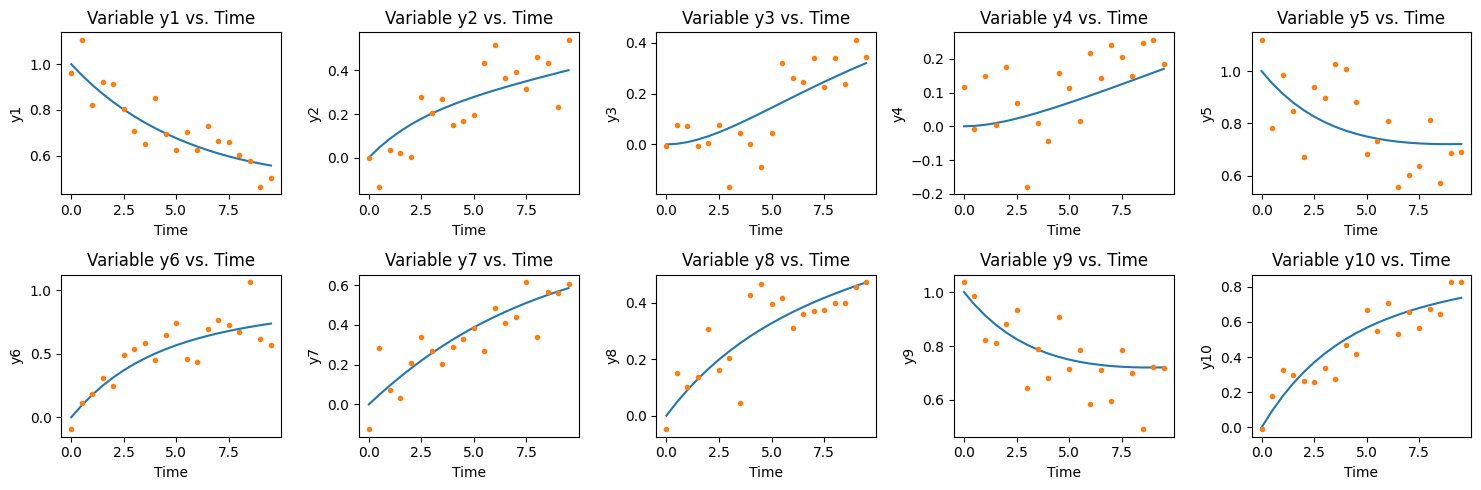

In [ ]:
########################################
# MCMC MODEL
########################################

# Define Numpyro model
def model():
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # parameters alpha, beta, gamma, delta of dz_dt
    k1 = numpyro.sample('k1', dist.Normal(0, 1))
    k2 = numpyro.sample('k2', dist.Normal(0, 1))
    k3 = numpyro.sample('k3', dist.Normal(0, 1))
    k4 = numpyro.sample('k4', dist.Normal(0, 1))
    k5 = numpyro.sample('k5', dist.Normal(0, 1))
    k6 = numpyro.sample('k6', dist.Normal(0, 1))
    k7 = numpyro.sample('k7', dist.Normal(0, 1))
    k8 = numpyro.sample('k8', dist.Normal(0, 1))
    k9 = numpyro.sample('k9', dist.Normal(0, 1))
    k10 = numpyro.sample('k10', dist.Normal(0, 1))

    #sol = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    sol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=[k1,k2,k3,k4,k5,k6,k7,k8,k9,k10], saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([10]))

    # measured populations
    numpyro.sample("y", dist.Normal(sol.ys, sigma), obs=yobs)

# use dense_mass for better mixing rate
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_warmup=1000,
    num_samples=4000,
    num_chains=1,
    progress_bar=True,
)
mcmc.run(PRNGKey(1))
mcmc.print_summary()

ds = az.from_numpyro(mcmc)

ds.posterior

# predict
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2))["y"]
mu = jnp.mean(pop_pred, 0)
pi = jnp.percentile(pop_pred, jnp.array([10, 90]), 0)

Plot Posterior

Shows the fit of the data using Bayesian model

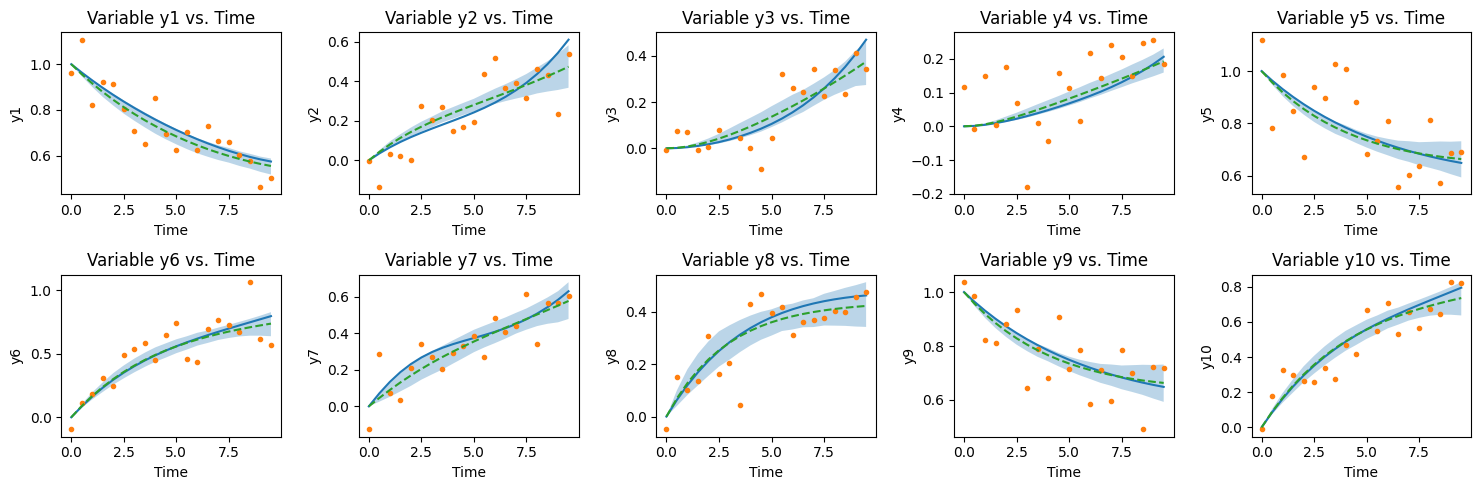

In [ ]:
import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

########################################
# PROCESS MCMC RESULTS
########################################

samples_1 = mcmc.get_samples()

# Compute empirical posterior distribution over mu
k1array = jnp.expand_dims(samples_1["k1"], -1)
k2array = jnp.expand_dims(samples_1["k2"], -1)
k3array = jnp.expand_dims(samples_1["k3"], -1)
k4array = jnp.expand_dims(samples_1["k4"], -1)
k5array = jnp.expand_dims(samples_1["k5"], -1)
k6array = jnp.expand_dims(samples_1["k6"], -1)
k7array = jnp.expand_dims(samples_1["k7"], -1)
k8array = jnp.expand_dims(samples_1["k8"], -1)
k9array = jnp.expand_dims(samples_1["k9"], -1)
k10array = jnp.expand_dims(samples_1["k10"], -1)

posterior_mu = np.empty((k1array.shape[0],sol.ys.shape[0],sol.ys.shape[1]))

for i in range(0,k1array.shape[0]):
    args = np.asarray([k1array[i][0],k2array[i][0],k3array[i][0],k4array[i][0],k5array[i][0],k6array[i][0],k7array[i][0],k8array[i][0],k9array[i][0],k10array[i][0]])
    sol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times), max_steps=10000)
    posterior_mu[i,:,:] = sol.ys

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.95)

# Generate separate subplots for each variable
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(sol.ts, sol.ys[:,i])
    axs[i].plot(sol.ts, yobs[:,i], '.')
    axs[i].plot(sol.ts, mean_mu[:,i], '--')
    axs[i].fill_between(sol.ts, hpdi_mu[0,:,i], hpdi_mu[1,:,i], alpha=0.3)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(f'y{i+1}')
    axs[i].set_title(f'Variable y{i+1} vs. Time')

plt.tight_layout()
plt.show()

Sensitivity analysis

Global sensitivity analysis using SALib.

https://salib.readthedocs.io/en/latest/user_guide/basics.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

# Redefine parameters
k1 = 0.1
k2 = 0.1
k3 = 0.1
k4 = 0.1
k5 = 0.1
k6 = 0.1
k7 = 0.1
k8 = 0.1
k9 = 0.1
k10 = 0.1
args = jnp.array([k1, k2, k3, k4, k5, k6, k7, k8, k9, k10])

# Define problem
problem = {
    'num_vars': 10,
    'names': ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10'],
    'bounds': [[0.5, 1.5]]*10
}

# Sample
param_values = saltelli.sample(problem, 1000)

# Evaluate model
Y = np.empty([param_values.shape[0], len(y0), len(times)])
for i, p in enumerate(param_values):
    sol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times), max_steps=10000)
    Y[i, :, :] = sol.ys.transpose()

# Calculate Sobol indices
Si = sobol.analyze(problem, Y, calc_second_order=True, print_to_console=False)

# Print first and second order sensitivities
for i, name in enumerate(problem['names']):
    print(f"{name}: {Si['S1'][i]}")

<ipython-input-5-7a8b2967ba0b>:28: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)


ValueError: ignored

3D Model Simulations

1D and 2D Finite Difference Can Be Used With JAX

In [ ]:
import argparse
import os
import arviz as az

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import diffrax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

import pandas as pd
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

import pyvista as pv
from google.colab import files

def dxdt(t, y, args):
    # Unwrap values
    # x1 = Neurons
    # x2 = Microglia
    # x3 = Astrocytes
    # x4 = Capillaries
    # x5 = Oxygen
    # x6 = TNF/IL
    # x7 = VEGF
    # x8 = BDNF
    # x9 = MMP
    # x10 = Extracellular Matrix
    x1 = y[0,:].reshape(n,n)
    x2 = y[1,:].reshape(n,n)
    x3 = y[2,:].reshape(n,n)
    x4 = y[3,:].reshape(n,n)
    x5 = y[4,:].reshape(n,n)
    x6 = y[5,:].reshape(n,n)
    x7 = y[6,:].reshape(n,n)
    x8 = y[7,:].reshape(n,n)
    x9 = y[8,:].reshape(n,n)
    x10 = y[9,:].reshape(n,n)

    # Unwrap parameters
    D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10 = args

    # PDEs
    dx1dt = D1*(jnp.gradient(jnp.gradient(x1, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x1, h, axis=0), h, axis=0)) - k1*x1 + k2*x2
    dx2dt = D2*(jnp.gradient(jnp.gradient(x2, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x2, h, axis=0), h, axis=0)) + k1*x1 - k2*x2
    dx3dt = D3*(jnp.gradient(jnp.gradient(x3, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x3, h, axis=0), h, axis=0)) + k3*x2*x4 - k4*x3 - k5*x3*x6 + k6*x2 - k7*x3*x8 + k8*x7
    dx4dt = D4*(jnp.gradient(jnp.gradient(x4, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x4, h, axis=0), h, axis=0)) + k9*x2 - k10*x4
    dx5dt = D5*(jnp.gradient(jnp.gradient(x5, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x5, h, axis=0), h, axis=0)) - k1*x5 + k2*x6
    dx6dt = D6*(jnp.gradient(jnp.gradient(x6, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x6, h, axis=0), h, axis=0)) + k1*x5 - k2*x6 - k3*x2*x6 + k4*x5 + k5*x3*x6 - k6*x2
    dx7dt = D7*(jnp.gradient(jnp.gradient(x7, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x7, h, axis=0), h, axis=0)) + k3*x2*x8 - k4*x7 - k5*x7*x6 + k6*x9 - k7*x3*x8 + k8*x7
    dx8dt = D8*(jnp.gradient(jnp.gradient(x8, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x8, h, axis=0), h, axis=0)) + k9*x9 - k10*x8
    dx9dt = D9*(jnp.gradient(jnp.gradient(x9, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x9, h, axis=0), h, axis=0)) - k1*x9 + k2*x10
    dx10dt = D10*(jnp.gradient(jnp.gradient(x10, h, axis=1), h, axis=1) + jnp.gradient(jnp.gradient(x10, h, axis=0), h, axis=0)) + k1*x9 - k2*x10 - k3*x2*x10 + k4*x9 + k5*x3*x10 - k6*x2

    drhodt = D_rho_rho*(jnp.gradient(jnp.gradient(rho, h, axis=0), h, axis=0) + jnp.gradient(jnp.gradient(rho, h, axis=1), h, axis=1)) + ((p_rho + p_rho_c*c/(K_rho_c + c))*(1-rho/K_rho_rho)*rho - d_rho*rho)
    dcdt = D_c_c*(jnp.gradient(jnp.gradient(c, h, axis=0), h, axis=0) + jnp.gradient(jnp.gradient(c, h, axis=1), h, axis=1)) + (p_c_rho*(rho/(K_c_c + c)) - d_c*c)

    # dBCs
    dx1dt = dx1dt.at[:,0].set(0.0)
    dx1dt = dx1dt.at[:,-1].set(0.0)
    dx1dt = dx1dt.at[0,:].set(0.0)
    dx1dt = dx1dt.at[-1,:].set(0.0)
    dx2dt = dx2dt.at[:,0].set(0.0)
    dx2dt = dx2dt.at[:,-1].set(0.0)
    dx2dt = dx2dt.at[0,:].set(0.0)
    dx2dt = dx2dt.at[-1,:].set(0.0)
    dx3dt = dx3dt.at[:,0].set(0.0)
    dx3dt = dx3dt.at[:,-1].set(0.0)
    dx3dt = dx3dt.at[0,:].set(0.0)
    dx3dt = dx3dt.at[-1,:].set(0.0)
    dx4dt = dx4dt.at[:,0].set(0.0)
    dx4dt = dx4dt.at[:,-1].set(0.0)
    dx4dt = dx4dt.at[0,:].set(0.0)
    dx4dt = dx4dt.at[-1,:].set(0.0)
    dx5dt = dx5dt.at[:,0].set(0.0)
    dx5dt = dx5dt.at[:,-1].set(0.0)
    dx5dt = dx5dt.at[0,:].set(0.0)
    dx5dt = dx5dt.at[-1,:].set(0.0)
    dx6dt = dx6dt.at[:,0].set(0.0)
    dx6dt = dx6dt.at[:,-1].set(0.0)
    dx6dt = dx6dt.at[0,:].set(0.0)
    dx6dt = dx6dt.at[-1,:].set(0.0)
    dx7dt = dx7dt.at[:,0].set(0.0)
    dx7dt = dx7dt.at[:,-1].set(0.0)
    dx7dt = dx7dt.at[0,:].set(0.0)
    dx7dt = dx7dt.at[-1,:].set(0.0)
    dx8dt = dx8dt.at[:,0].set(0.0)
    dx8dt = dx8dt.at[:,-1].set(0.0)
    dx8dt = dx8dt.at[0,:].set(0.0)
    dx8dt = dx8dt.at[-1,:].set(0.0)
    dx9dt = dx9dt.at[:,0].set(0.0)
    dx9dt = dx9dt.at[:,-1].set(0.0)
    dx9dt = dx9dt.at[0,:].set(0.0)
    dx9dt = dx9dt.at[-1,:].set(0.0)
    dx10dt = dx10dt.at[:,0].set(0.0)
    dx10dt = dx10dt.at[:,-1].set(0.0)
    dx10dt = dx10dt.at[0,:].set(0.0)
    dx10dt = dx10dt.at[-1,:].set(0.0)

    return jnp.stack([dx1dt.flatten(), dx2dt.flatten(), dx3dt.flatten(), dx4dt.flatten(), dx5dt.flatten(),
                           dx6dt.flatten(), dx7dt.flatten(), dx8dt.flatten(), dx9dt.flatten(), dx10dt.flatten()])

terms = ODETerm(dxdt)

# Define parameters
n = 100
h = 2 / n
D1 = 0.001
D2 = 0.001
D3 = 0.001
D4 = 0.001
D5 = 0.001
D6 = 0.001
D7 = 0.001
D8 = 0.001
D9 = 0.001
D10 = 0.001
k1 = 0.1
k2 = 0.1
k3 = 0.1
k4 = 0.1
k5 = 0.1
k6 = 0.1
k7 = 0.1
k8 = 0.1
k9 = 0.1
k10 = 0.1
args = jnp.array([D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, k1, k2, k3, k4, k5, k6, k7, k8, k9, k10])

# Set the initial conditions and time points
dt0 = 0.01
t0 = 0
tf = 10
times = np.arange(0, 10, 0.5)

x1_0 = np.ones((n, n))
x2_0 = np.ones((n, n))
x3_0 = np.ones((n, n))
x4_0 = np.zeros((n, n))
x5_0 = np.zeros((n, n))
x6_0 = np.zeros((n, n))
x7_0 = np.ones((n, n))
x8_0 = np.ones((n, n))
x9_0 = np.zeros((n, n))
x10_0 = np.ones((n, n))

x = np.linspace(-1, 1, n)
y = np.linspace(-1, 1, n)
X, Y = np.meshgrid(x, y)

r = np.sqrt(X ** 2 + Y ** 2)
x1_0[r < 0.2] = 0
x2_0[r < 0.2] = 0
x3_0[r < 0.2] = 0
x4_0[r < 0.2] = 1
x5_0[r < 0.2] = 1
x6_0[r < 0.2] = 1
x7_0[r < 0.2] = 0
x8_0[r < 0.2] = 0
x9_0[r < 0.2] = 1
x10_0[r < 0.2] = 0

y0 = jnp.stack([x1_0.flatten(), x2_0.flatten(), x3_0.flatten(), x4_0.flatten(), x5_0.flatten(),
                x6_0.flatten(), x7_0.flatten(), x8_0.flatten(), x9_0.flatten(), x10_0.flatten()])

# Initialize solver
solver = Dopri5()
#solver = Euler()
#stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(terms, solver=solver, t0=t0, t1=tf, dt0=dt0, y0=y0, args=args, saveat=SaveAt(ts=times), max_steps=10000)
                  #stepsize_controller=stepsize_controller)

# print(sol.ts)
print(sol.ys.shape)

# define output folder.
if not os.path.isdir('FDresults'):
    os.mkdir('FDresults')

mesh = pv.StructuredGrid(X,Y,np.zeros_like(X))
for t in range(0,times.shape[0]):
    mesh['x1'] = sol.ys.T[:,:,t][:,0].reshape(n,n).flatten()
    mesh['x2'] = sol.ys.T[:,:,t][:,1].reshape(n,n).flatten()
    mesh['x3'] = sol.ys.T[:,:,t][:,2].reshape(n,n).flatten()
    mesh['x4'] = sol.ys.T[:,:,t][:,3].reshape(n,n).flatten()
    mesh['x5'] = sol.ys.T[:,:,t][:,4].reshape(n,n).flatten()
    mesh['x6'] = sol.ys.T[:,:,t][:,5].reshape(n,n).flatten()
    mesh['x7'] = sol.ys.T[:,:,t][:,6].reshape(n,n).flatten()
    mesh['x8'] = sol.ys.T[:,:,t][:,7].reshape(n,n).flatten()
    mesh['x9'] = sol.ys.T[:,:,t][:,8].reshape(n,n).flatten()
    mesh['x10'] = sol.ys.T[:,:,t][:,9].reshape(n,n).flatten()
    mesh.save('FDresults/solution_' + str(t) + '.vtk')

!zip -r FDresults.zip FDresults
files.download("FDresults.zip")


(20, 10, 10000)
  adding: FDresults/ (stored 0%)
  adding: FDresults/solution_19.vtk (deflated 78%)
  adding: FDresults/solution_2.vtk (deflated 89%)
  adding: FDresults/solution_6.vtk (deflated 86%)
  adding: FDresults/solution_0.vtk (deflated 95%)
  adding: FDresults/solution_14.vtk (deflated 80%)
  adding: FDresults/solution_1.vtk (deflated 91%)
  adding: FDresults/solution_15.vtk (deflated 80%)
  adding: FDresults/solution_3.vtk (deflated 88%)
  adding: FDresults/solution_16.vtk (deflated 79%)
  adding: FDresults/solution_4.vtk (deflated 87%)
  adding: FDresults/solution_9.vtk (deflated 83%)
  adding: FDresults/solution_18.vtk (deflated 78%)
  adding: FDresults/solution_11.vtk (deflated 82%)
  adding: FDresults/solution_13.vtk (deflated 80%)
  adding: FDresults/solution_17.vtk (deflated 79%)
  adding: FDresults/solution_12.vtk (deflated 81%)
  adding: FDresults/solution_8.vtk (deflated 84%)
  adding: FDresults/solution_10.vtk (deflated 82%)
  adding: FDresults/solution_5.vtk (defla

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dimensionality Reduction

Do Scipy PCA on 3D simulations to make easier to analyze

Alternatively, can extract relevant features such as the wound area, cell count, matrix density, etc for surrogate model

In [ ]:
# Import required libraries
!pip install pyvista

In [ ]:
# -*- coding: utf-8 -*-
"""
Code to Read and Analyze Wound Healing Meshes

Created on Thu Nov 19 21:55:05 2020

@author: David
"""

import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path

# Load in mesh files
num_samples = 1
t_max = 7001
t_sample_rate = 20
t_samples = int(t_max/t_sample_rate)

# Data
x1data = np.array([])
x2data = np.array([])
x3data = np.array([])
x4data = np.array([])
x5data = np.array([])
x6data = np.array([])
x7data = np.array([])
x8data = np.array([])
x9data = np.array([])
x10data = np.array([])

for time in range(0,t_samples,1):
    # Set a threshold value for collagen
    thresh_val = 0.3

    # Read each of the files
    if path.exists("20_normal/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk"):
        meshNormal = pv.read("20_normal/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk")

        # Create a new array for the collagen density
        meshNormal.point_arrays['collagen'] = meshNormal.point_arrays['rho_c_phif_kappa'][:,2]

        # Convert cell data to point data
        meshNormal_cell_data = meshNormal.point_data_to_cell_data(True)

        if(time == 0):
            # Extract cells that are above threshold
            classifierNormal  = meshNormal_cell_data.cell_arrays['collagen'] < thresh_val

            # Get center cell
            centerpointNormal = meshNormal_cell_data.find_closest_point((37.5,37.5,2.))

        # Get cell sizes
        sizesNormal = meshNormal_cell_data.compute_cell_sizes()
        areasNormal = sizesNormal.cell_arrays["Volume"]

        # Choose cells inside wound
        idx = np.argwhere(classifierNormal)
        area_data_Normal = np.append(area_data_Normal, np.sum(areasNormal[idx]))

        rho_data_Normal = np.append(rho_data_Normal, meshNormal.point_arrays['rho_c_phif_kappa'][centerpointNormal,0])
        c_data_Normal = np.append(c_data_Normal, meshNormal.point_arrays['rho_c_phif_kappa'][centerpointNormal,1])
        phif_data_Normal = np.append(phif_data_Normal, meshNormal.point_arrays['rho_c_phif_kappa'][centerpointNormal,2])
        kappa_data_Normal = np.append(kappa_data_Normal, meshNormal.point_arrays['rho_c_phif_kappa'][centerpointNormal,3])

    if path.exists("20_smaller/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk"):
        meshSmaller = pv.read("20_smaller/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk")

        meshSmaller.point_arrays['collagen'] = meshSmaller.point_arrays['rho_c_phif_kappa'][:,2]

        meshSmaller_cell_data = meshSmaller.point_data_to_cell_data(True)

        if(time == 0):
        # Extract cells that are above threshold
            classifierSmaller  = meshSmaller_cell_data.cell_arrays['collagen'] < thresh_val

            # Get center cell
            centerpointSmaller = meshSmaller_cell_data.find_closest_point((37.5,37.5,2.))

        sizesSmaller = meshSmaller_cell_data.compute_cell_sizes()
        areasSmaller = sizesSmaller.cell_arrays["Volume"]

        idx = np.argwhere(classifierSmaller)
        area_data_Smaller = np.append(area_data_Smaller, np.sum(areasSmaller[idx]))

        rho_data_Smaller = np.append(rho_data_Smaller, meshSmaller.point_arrays['rho_c_phif_kappa'][centerpointSmaller,0])
        c_data_Smaller = np.append(c_data_Smaller, meshSmaller.point_arrays['rho_c_phif_kappa'][centerpointSmaller,1])
        phif_data_Smaller = np.append(phif_data_Smaller, meshSmaller.point_arrays['rho_c_phif_kappa'][centerpointSmaller,2])
        kappa_data_Smaller = np.append(kappa_data_Smaller, meshSmaller.point_arrays['rho_c_phif_kappa'][centerpointSmaller,3])

    if path.exists("20_larger/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk"):
        meshLarger = pv.read("20_larger/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk")

        meshLarger.point_arrays['collagen'] = meshLarger.point_arrays['rho_c_phif_kappa'][:,2]

        meshLarger_cell_data = meshLarger.point_data_to_cell_data(True)

        if(time == 0):
            # Extract cells that are above threshold
            classifierLarger  = meshLarger_cell_data.cell_arrays['collagen'] < thresh_val

            # Get center cell
            centerpointLarger = meshLarger_cell_data.find_closest_point((37.5,37.5,2.))

        sizesLarger = meshLarger_cell_data.compute_cell_sizes()
        areasLarger = sizesLarger.cell_arrays["Volume"]

        idx = np.argwhere(classifierLarger)
        area_data_Larger = np.append(area_data_Larger, np.sum(areasLarger[idx]))

        rho_data_Larger = np.append(rho_data_Larger, meshLarger.point_arrays['rho_c_phif_kappa'][centerpointLarger,0])
        c_data_Larger = np.append(c_data_Larger, meshLarger.point_arrays['rho_c_phif_kappa'][centerpointLarger,1])
        phif_data_Larger = np.append(phif_data_Larger, meshLarger.point_arrays['rho_c_phif_kappa'][centerpointLarger,2])
        kappa_data_Larger = np.append(kappa_data_Larger, meshLarger.point_arrays['rho_c_phif_kappa'][centerpointLarger,3])

    if path.exists("20_elliptical/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk"):
        meshElliptical = pv.read("20_elliptical/paraviewoutput_" + str(time*t_sample_rate + 1) + ".vtk")

        meshElliptical.point_arrays['collagen'] = meshElliptical.point_arrays['rho_c_phif_kappa'][:,2]

        meshElliptical_cell_data = meshElliptical.point_data_to_cell_data(True)

        if(time == 0):
            # Extract cells that are above threshold
            classifierElliptical  = meshElliptical_cell_data.cell_arrays['collagen'] < thresh_val

            # Get center cell
            centerpointElliptical = meshElliptical_cell_data.find_closest_point((37.5,37.5,2.))

        sizesElliptical = meshElliptical_cell_data.compute_cell_sizes()
        areasElliptical = sizesElliptical.cell_arrays["Volume"]

        idx = np.argwhere(classifierElliptical)
        area_data_Elliptical = np.append(area_data_Elliptical, np.sum(areasElliptical[idx]))

        rho_data_Elliptical = np.append(rho_data_Elliptical, meshElliptical.point_arrays['rho_c_phif_kappa'][centerpointElliptical,0])
        c_data_Elliptical = np.append(c_data_Elliptical, meshElliptical.point_arrays['rho_c_phif_kappa'][centerpointElliptical,1])
        phif_data_Elliptical = np.append(phif_data_Elliptical, meshElliptical.point_arrays['rho_c_phif_kappa'][centerpointElliptical,2])
        kappa_data_Elliptical = np.append(kappa_data_Elliptical, meshElliptical.point_arrays['rho_c_phif_kappa'][centerpointElliptical,3])

# rho_data_Larger = np.append(rho_data_Larger, 1.6)
# area_data_Larger = np.append(area_data_Larger, np.sum(areasLarger[idx]))

fig,ax = plt.subplots(1,5, figsize=(30, 6))

ax[0].set_ylabel('Cell Density')
ax[0].set_xlabel('Time (d)')
ax[1].set_ylabel('Cytokine Density')
ax[1].set_xlabel('Time (d)')
ax[2].set_ylabel('Collagen Density')
ax[2].set_xlabel('Time (d)')
ax[3].set_ylabel('Collagen Dispersion')
ax[3].set_xlabel('Time (d)')
ax[4].set_ylabel('Relative Area')
ax[4].set_xlabel('Time (d)')

# ax[0].set_ylim(0,2)
# ax[1].set_ylim(0,1)
# ax[2].set_ylim(0,1)
# ax[3].set_ylim(0,0.5)
# ax[4].set_ylim(0,1)

ax[0].set_xlim(0,330)
ax[1].set_xlim(0,330)
ax[2].set_xlim(0,330)
ax[3].set_xlim(0,330)
ax[4].set_xlim(0,330)
ax[4].set_ylim(0,1.2)

ax[0].plot(rho_data_Normal)
ax[1].plot(c_data_Normal)
ax[2].plot(phif_data_Normal)
ax[3].plot(kappa_data_Normal)
ax[4].plot(area_data_Normal/area_data_Normal[0], label = 'Normal')

ax[0].plot(rho_data_Smaller)
ax[1].plot(c_data_Smaller)
ax[2].plot(phif_data_Smaller)
ax[3].plot(kappa_data_Smaller)
ax[4].plot(area_data_Smaller/area_data_Smaller[0], label = 'Smaller')

ax[0].plot(rho_data_Larger)
ax[1].plot(c_data_Larger)
ax[2].plot(phif_data_Larger)
ax[3].plot(kappa_data_Larger)
ax[4].plot(area_data_Larger/area_data_Larger[0], label = 'Larger')

ax[0].plot(rho_data_Elliptical)
ax[1].plot(c_data_Elliptical)
ax[2].plot(phif_data_Elliptical)
ax[3].plot(kappa_data_Elliptical)
ax[4].plot(area_data_Elliptical/area_data_Elliptical[0], label = 'Elliptical')

ax[4].legend(loc='best')

plt.show()

time = np.linspace(0,14,336)

fig,ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].set_ylabel('Cell Density')
ax[0].set_xlabel('Time (d)')
ax[1].set_ylabel('Relative Area')
ax[1].set_xlabel('Time (d)')

# ax[0].set_ylim(0,2)
# ax[1].set_ylim(0,1)
# ax[2].set_ylim(0,1)
# ax[3].set_ylim(0,0.5)
# ax[4].set_ylim(0,1)

ax[0].set_xlim(0,14)
ax[1].set_xlim(0,14)
#ax[0].set_ylim(0,2.2)
ax[1].set_ylim(0,1.2)

ax[0].plot(time[0:331], rho_data_Normal/1000)
ax[1].plot(time[0:331], area_data_Normal/area_data_Normal[0], label = 'Normal')

ax[0].plot(time[0:334], rho_data_Smaller/1000)
ax[1].plot(time[0:334], area_data_Smaller/area_data_Smaller[0], label = 'Smaller')

ax[0].plot(np.append(time[0:291],13.8), np.append(rho_data_Larger/1000,1.6))
ax[1].plot(np.append(time[0:291],13.8), np.append(area_data_Larger/area_data_Larger[0],0.35), label = 'Larger')

ax[0].plot(time[0:331], rho_data_Elliptical/1000)
ax[1].plot(time[0:331], area_data_Elliptical/area_data_Elliptical[0], label = 'Elliptical')

ax[1].legend(loc='best')

plt.subplots_adjust(wspace = 0.3)
plt.show()

Gaussian Process Regression

GPFlow

In [ ]:
!pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.7/376.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.2 MB/s eta 0:00:00


(<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[3.75907766],
        [4.28009566],
        [3.71506022]])>,
 <tf.Tensor: shape=(1, 3, 3), dtype=float64, numpy=
 array([[[0.17286964, 0.18033224, 0.04013752],
         [0.18033224, 0.30584767, 0.12780391],
         [0.04013752, 0.12780391, 0.11372553]]])>)

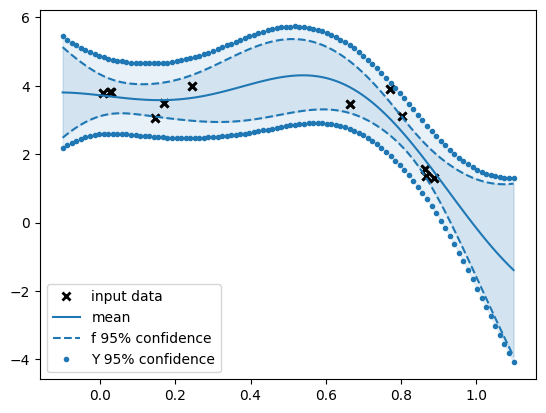

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow

X = np.array(
    [
        [0.865], [0.666], [0.804], [0.771], [0.147], [0.866], [0.007], [0.026],
        [0.171], [0.889], [0.243], [0.028],
    ]
)
Y = np.array(
    [
        [1.57], [3.48], [3.12], [3.91], [3.07], [1.35], [3.80], [3.82], [3.49],
        [1.30], [4.00], [3.82],
    ]
)

plt.plot(X, Y, "kx", mew=2)

model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.SquaredExponential(),
)

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

Xnew = np.array([[0.5]])
model.predict_f(Xnew)

model.predict_y(Xnew)

Xplot = np.linspace(-0.1, 1.1, 100)[:, None]

f_mean, f_var = model.predict_f(Xplot, full_cov=False)
y_mean, y_var = model.predict_y(Xplot)

f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

plt.plot(X, Y, "kx", mew=2, label="input data")
plt.plot(Xplot, f_mean, "-", color="C0", label="mean")
plt.plot(Xplot, f_lower, "--", color="C0", label="f 95% confidence")
plt.plot(Xplot, f_upper, "--", color="C0")
plt.fill_between(
    Xplot[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.1
)
plt.plot(Xplot, y_lower, ".", color="C0", label="Y 95% confidence")
plt.plot(Xplot, y_upper, ".", color="C0")
plt.fill_between(
    Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color="C0", alpha=0.1
)
plt.legend()

Xnew = np.array([[0.3], [0.5], [0.7]])
model.predict_f(Xnew, full_cov=False)

model.predict_f(Xnew, full_cov=True)

Polynomial Chaos

Non-intrusive uncertainty quantification

In [ ]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
build                         0.10.0
CacheControl                  0.12.11
cac